In [16]:

from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb,ZScaleInterval,SqrtStretch, MinMaxInterval, LogStretch, SinhStretch, AsinhStretch, PowerStretch, LinearStretch
import glob
from matplotlib.colors import ListedColormap
import os
import numpy as np


>f8


C:\Users\613287\AppData\Local\Temp\1\ipykernel_20080\1884630479.py:84: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


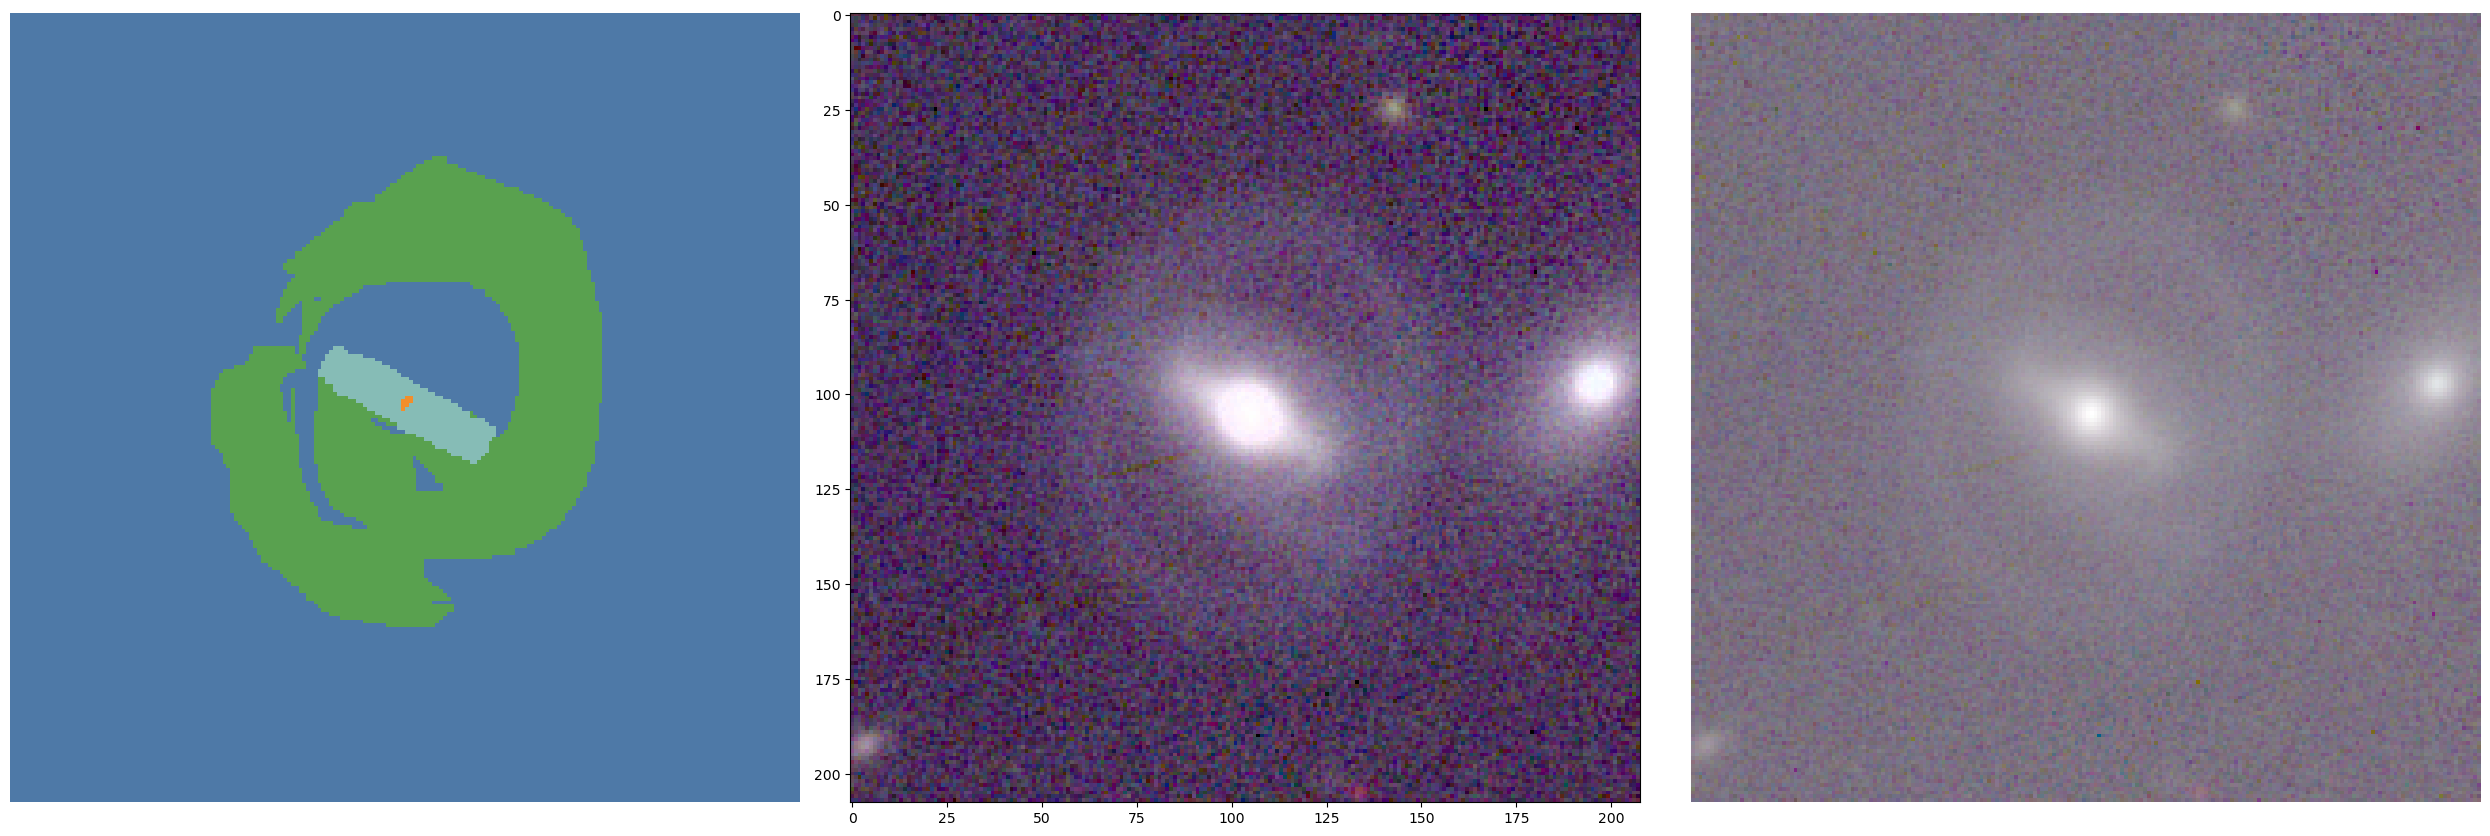

In [21]:

# define the training data path on the machine, change this to reflect the path in which you have placed your training data

training_data_path = 'C:/Users/613287/Desktop/ai_ml_training/galaxyzoo_3d/training_data/'

# make list of all the masks that exist
# The data file naming conventions are such that mask_<objectidentifier>.fits and imagedata_<objectidentifier>.fits exist for each object identifier.
# 
# As a quick pass, we're just using the the mask files to extract out all the unique object identifiers
# by making a list of all the mask files (mask_files) and then running a do loop to: split the filenames into the filename  
# and the filename extension, then take the filename and split it into the prefix and the identifier and append the identifier
# to the list of object identifiers
mask_files= glob.glob(training_data_path+'mask*.fits')
object_identifiers = []

for file in mask_files:
    filename, suffix = os.path.splitext(os.path.basename(file))
    prefix, identifier = filename.split('_')
    object_identifiers.append(identifier)


# to visualize the mask data which should have values between 0 and 4 where 0 = no label, 1 = identified galaxy centers,
# 2 = identified galaxy bars, 3 = identified galaxy arms and 4= identified star positions
# we make our own matplotlib colormap that assigns orange to values of 0, blue to values of 1, red to values of 2, teal to values of 3, and green to values of 4
colors = ["#4E79A7", "#F28E2B", "#E15759", "#86BCB6", "#59A14F" ]  
mask_cmap = ListedColormap(colors)


# call out a specific object identifer to plot
needed_obj = object_identifiers[451]


# the image data are in fits, and there are 5 arrays contained in the file, they contain imagery data from Pan-STARRS in the order of  
# the g filter, the r filter, the i filter, the z filter, and the y filter. A description of the filter transmissions can be found in 
# the Pan-STARRS documentation at Space Telescope Science Institute: https://outerspace.stsci.edu/display/PANSTARRS/PS1+Filter+properties
# this notebook uses the getdata feature of the fits module for astropy but data can also be accessed by:
# opening a fits images with 'fitsdata = fits.open(<filename>)'
# and accessing the first data array with 'imagedata_g = fitsdata[0].data'
image_data_g = fits.getdata(training_data_path+'imagedata_'+str(needed_obj)+'.fits',0)
image_data_r = fits.getdata(training_data_path+'imagedata_'+str(needed_obj)+'.fits',1)
image_data_i = fits.getdata(training_data_path+'imagedata_'+str(needed_obj)+'.fits',2)
image_data_z = fits.getdata(training_data_path+'imagedata_'+str(needed_obj)+'.fits',3)
image_data_y = fits.getdata(training_data_path+'imagedata_'+str(needed_obj)+'.fits',4)


# to visualize the imaging data we need to define both a scaling function and a minimum and maximum range to display
# the equations for the common scaling functions in astrophysics are given at the following site: http://ds9.si.edu/doc/ref/how.html
# In addition to stretch an interval over which to calculate the stretch can be defined. MinMaxInterval scans the data for the minimum and maximum
# values, ZScaleInterval is described with equations on this page: https://js9.si.edu/js9/plugins/help/scalecontrols.html
# the results are scaled such that calues are between 0 and 1
stretch = LogStretch()+MinMaxInterval()

# apply the stretch to three specific filters
image_data_g_stretched = stretch(image_data_g)
image_data_r_stretched = stretch(image_data_r)
image_data_z_stretched = stretch(image_data_z)



# calculate the new min/max values from the 0.5% and 99.5% percentiles of the three images and use that to calculate a range
low_value, high_value = np.percentile(np.hstack((image_data_g_stretched.flatten(), image_data_r_stretched.flatten(), image_data_z_stretched.flatten())), (0.5, 99.5))
stretch_range = high_value - low_value


# creates a three color image based on the article by Lupton et al: https://arxiv.org/pdf/astro-ph/0312483.pdf
# this uses an asinh stretch with a softening parameter Q. The default values are such that stretch (or the range between minimum and maximum values) is equal to 5,
# and Q = 8.
three_color_array = make_lupton_rgb(image_data_z_stretched, image_data_r_stretched, image_data_g_stretched, stretch=stretch_range, minimum = low_value, Q=0)



# as an alternate option to the use of make_lupton_rgb, one can also simply create a 3 band array of images using the 
# numpy dstack function 
alt_three_color_array = np.dstack((image_data_z_stretched, image_data_r_stretched, image_data_g_stretched))


mask_image = fits.getdata(training_data_path+'mask_'+str(needed_obj)+'.fits')
mask_image = mask_image.astype('int')



# quickly make plots in matplotlib that show: the mask on the left, the result of make_lupton_rgb in the middle, and the numpy stack of arrays for an rgb on the right
plt.subplots(figsize=(25,25))
plt.subplot(1,3,1)
plt.imshow(mask_image, cmap=mask_cmap)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(three_color_array)
plt.subplot(1,3,3)
plt.imshow(alt_three_color_array)
plt.axis('off')
plt.tight_layout()
plt.show()
